# DOSSIER SVM ET RESEAUX DE NEURONES : 
## Prévision du prix des maisons

Notre objectif pour cette étude sera à partir d'un jeu de donnée, prédire une variable cible en utilisant des méthode de Machine Learning à savoir les SVM (Support Vector Machine) et les reseaux de neurones artificiels (ANN) mais aussi déterminer l'importance des variables en utilisant les méthodes RandomForest.

In [1]:
# Importation des packages

import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



#Regressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR

# Evaluation
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as mt
from sklearn_evaluation import plot
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#Reseaux de neurone
import tensorflow as tf
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasClassifier, KerasRegressor

from sklearn.ensemble import RandomForestRegressor
#Web request
import requests
import io

## 1. Importation du jeu de donnée

In [2]:
# Importation des bases de données

path = "C:/Users/HP/Downloads/BBD/housing_price_dataset.csv"

house = pd.read_csv(path, sep= ",",
              na_values ="?" )


In [3]:
house

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065
...,...,...,...,...,...,...
49995,1282,5,3,Rural,1975,100080.865895
49996,2854,2,2,Suburb,1988,374507.656727
49997,2979,5,3,Suburb,1962,384110.555590
49998,2596,5,2,Rural,1984,380512.685957


In [4]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SquareFeet    50000 non-null  int64  
 1   Bedrooms      50000 non-null  int64  
 2   Bathrooms     50000 non-null  int64  
 3   Neighborhood  50000 non-null  object 
 4   YearBuilt     50000 non-null  int64  
 5   Price         50000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.3+ MB


Notre base de donnée est composée de 6 variables. Notre variable cible correspond au prix de vente des maisons 'Price'. Avant de passer à la modélisation, nous allons effectué un prétraitement de nos données afin de supprimer tout ce qui est valeurs manquantes et outliers.

## 2. Data cleaning

In [5]:
# Transformation de notre variable Neighborhood en catégorielle
for col in house.columns:
    if house[col].dtype == "object":
        house[col] = house[col].astype("category")
        
# Création d'une nouvelle variable correspond à l'age(ancienneté de la maison)
house['Age'] = pd.to_datetime('now').year - house['YearBuilt']    

# Suppression de la variable 'YearBuilt'
house.drop(["YearBuilt"], axis = 1, inplace = True)
        
house.info()     

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   SquareFeet    50000 non-null  int64   
 1   Bedrooms      50000 non-null  int64   
 2   Bathrooms     50000 non-null  int64   
 3   Neighborhood  50000 non-null  category
 4   Price         50000 non-null  float64 
 5   Age           50000 non-null  int64   
dtypes: category(1), float64(1), int64(4)
memory usage: 2.0 MB


Nous avons tout d'abord transformé la variable 'Neighborhood' en catégorielle, puis crée une nouvelle variable 'Age' qui correspond à l'ancienneté de la maison et supprimer la variable 'YearBuilt' pour éviter des erreurs lors de modélisation avec le format datetime.

In [6]:
# Déterminons les valeurs manquantes

na_house = house.isna().sum()
na_house.sort_values()

SquareFeet      0
Bedrooms        0
Bathrooms       0
Neighborhood    0
Price           0
Age             0
dtype: int64

Nous constatons que notre jeu de donnée ne contient aucune valeurs manquantes.

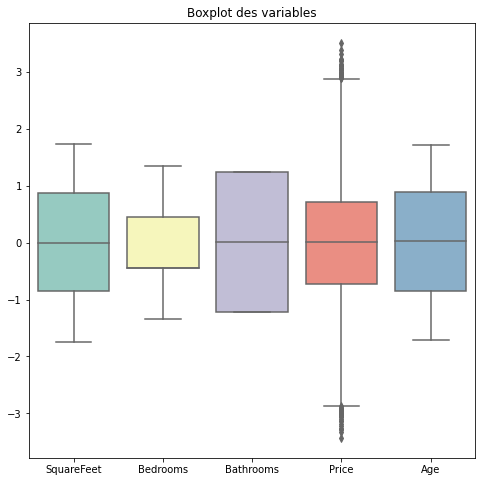

In [7]:
# Déterminons les outliers

# on retire la variable Neighborhood
features = house.drop('Neighborhood', axis=1).columns

# Appliquer la standardization (z-score)
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(house[features]), columns=features)
plt.figure(figsize=(8, 8))
sns.boxplot(data=data_scaled, palette='Set3')
plt.title('Boxplot des variables')

# Afficher le graphique
plt.show()

Pour identifier si nos données contiennent des outliers, nous avons construit les boxplots des variables. Nous constatons que seule la variable 'Price' a des valeurs extrêmes.

In [8]:
# Suppression des outliers présents dans la variable Price

# IQR
Q1 = np.percentile(house['Price'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(house['Price'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

# Upper bound
upper = np.where(house['Price'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(house['Price'] <= (Q1-1.5*IQR))
 
''' Removing the Outliers '''
house.drop(upper[0], inplace = True)
house.drop(lower[0], inplace = True)
 
print(house)

       SquareFeet  Bedrooms  Bathrooms Neighborhood          Price  Age
0            2126         4          1        Rural  215355.283618   55
1            2459         3          2        Rural  195014.221626   44
2            1860         2          1       Suburb  306891.012076   54
3            2294         2          1        Urban  206786.787153   28
4            2130         5          2       Suburb  272436.239065   23
...           ...       ...        ...          ...            ...  ...
49995        1282         5          3        Rural  100080.865895   49
49996        2854         2          2       Suburb  374507.656727   36
49997        2979         5          3       Suburb  384110.555590   62
49998        2596         5          2        Rural  380512.685957   40
49999        1572         5          3        Rural  221618.583218   13

[49941 rows x 6 columns]


Après avoir supprimer les outliers présents dans la variable 'Price', le nombre d'observation passe de 50000 à 49941, soit 59 outliers.

## 3. Analyse Statistique

<AxesSubplot:xlabel='Price', ylabel='Count'>

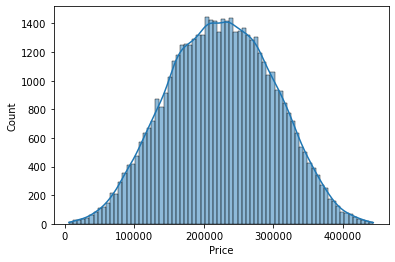

In [9]:
# Représentation grahique de notre variable cible 'Price'
sns.histplot(data=house , x = 'Price', kde=True)

In [10]:
# Statistiques descriptives
house.describe()

,SquareFeet,Bedrooms,Bathrooms,Price,Age
count,49941.000000,49941.000000,49941.000000,49941.000000,49941.000000
mean,2006.363309,3.498628,1.995495,224822.916361,38.593841
std,575.052125,1.116243,0.815842,75762.867779,20.720412
min,1000.000000,2.000000,1.000000,6124.032174,3.000000
25%,1513.000000,3.000000,1.000000,170000.830619,21.000000
50%,2007.000000,3.000000,2.000000,225051.077588,39.000000
75%,2505.000000,4.000000,3.000000,279320.164453,57.000000
max,2999.000000,5.000000,3.000000,443335.494338,74.000000


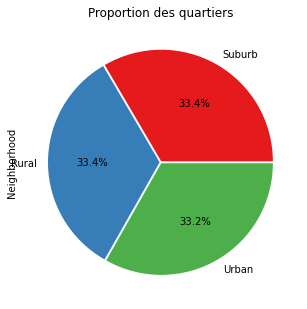

In [11]:
# Représentation des modalités de la variable 'Neighborhood'
p = house['Neighborhood'].value_counts().plot(kind='pie',
                                                figsize=(5, 6),
                                                title = 'Proportion des quartiers',
                                                autopct= '%1.1f%%' ,
                                                colors=["#e41a1c", "#377eb8","#4daf4a"],
                                                explode=(0.01, 0.01, 0.01)
                                                )

In [12]:
# Etude de la corrélation entre les variables 

corr = house.corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm')

,SquareFeet,Bedrooms,Bathrooms,Price,Age
SquareFeet,1.000000,-0.002892,-0.003733,0.759146,-0.000583
Bedrooms,-0.002892,1.000000,0.007619,0.070154,-0.003185
Bathrooms,-0.003733,0.007619,1.000000,0.026780,-0.003892
Price,0.759146,0.070154,0.026780,1.000000,0.000690
Age,-0.000583,-0.003185,-0.003892,0.000690,1.000000


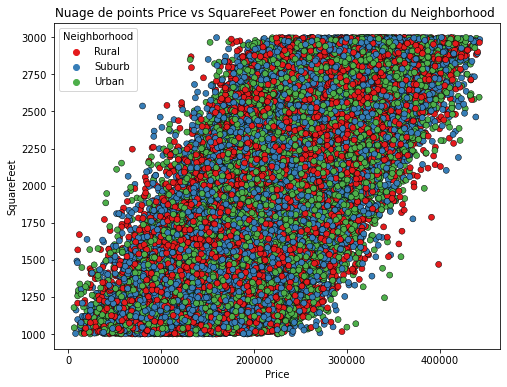

In [13]:
# Etude de la relation entre les variables 'Price', 'Neighborhood' et 'SquareFeet'
#Nuage de points
plt.figure(figsize=(8, 6))
scatter_plot = sns.scatterplot(data=house, x='Price', y='SquareFeet', hue='Neighborhood', palette='Set1', edgecolor='black')

plt.gcf()

# Ajouter des titres
plt.xlabel("Price")
plt.ylabel("SquareFeet")
plt.title("Nuage de points Price vs SquareFeet Power en fonction du Neighborhood ")

# Afficher le graphique
plt.show()

In [14]:
# Avant de modéliser nous allons encoder la variable 'Neighborhood' pour eviter les problèmes d'echelle

encoder = LabelEncoder()
house["Neighborhood"] = encoder.fit_transform(house[["Neighborhood"]])


C:\Users\HP\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
house

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,Price,Age
0,2126,4,1,0,215355.283618,55
1,2459,3,2,0,195014.221626,44
2,1860,2,1,1,306891.012076,54
3,2294,2,1,2,206786.787153,28
4,2130,5,2,1,272436.239065,23
...,...,...,...,...,...,...
49995,1282,5,3,0,100080.865895,49
49996,2854,2,2,1,374507.656727,36
49997,2979,5,3,1,384110.555590,62
49998,2596,5,2,0,380512.685957,40


## 4. Modélisation

In [16]:
# Diviser la variable cible des variable explicatives
X = house.drop(columns=['Price'], axis=1)
Y = house['Price']
print(X.shape)
print(Y.shape)

(49941, 5)
(49941,)


## 4.1 Modèles SVM

In [17]:
# Métriques pour évaluer la performance des modèles
def evaluate_performance(y_test,y_pred):
    # Assuming y_true and y_pred are actual and predicted values
    mae = mt.mean_absolute_error(y_test, y_pred)
    mse = mt.mean_squared_error(y_test, y_pred)
    rmse = mt.mean_squared_error(y_test, y_pred, squared=False)
    r2 = mt.r2_score(y_test, y_pred)

    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"R-squared: {r2}")

In [18]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Normalisation des données
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Création du modèle SVR                                  
svr_linear_100 = SVR(kernel='linear', C=100,  gamma="auto")
                                   

# Entraînement du modèle
svr_linear_100.fit(X_train_scaled, y_train)

# Prédiction sur l'ensemble de test
y_pred = svr_linear_100.predict(X_test_scaled)


# Évaluation du modèle
evaluate_performance(y_test,y_pred)

MAE: 39870.37317993514
MSE: 2469082535.265524
RMSE: 49689.86350620742
R-squared: 0.56673250771317


In [19]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Normalisation des données
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Création du modèle SVR                                   
svr_rbf_100= SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
                                   

# Entraînement du modèle
svr_rbf_100.fit(X_train_scaled, y_train)

# Prédiction sur l'ensemble de test
y_pred = svr_rbf_100.predict(X_test_scaled)


# Évaluation du modèle
evaluate_performance(y_test,y_pred)

MAE: 41020.44269055989
MSE: 2627970968.598596
RMSE: 51263.739315412764
R-squared: 0.5388512230333931


In [20]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Normalisation des données
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Création du modèle SVR                                   
svr_poly_100 =  SVR(kernel="poly", C=100, gamma="auto", epsilon=0.1)
                                   

# Entraînement du modèle
svr_poly_100.fit(X_train_scaled, y_train)

# Prédiction sur l'ensemble de test
y_pred = svr_poly_100.predict(X_test_scaled)


# Évaluation du modèle
evaluate_performance(y_test,y_pred)

MAE: 42168.111997310865
MSE: 2787512376.070275
RMSE: 52796.89740950954
R-squared: 0.5108553563323506


In [21]:
svm_models = [svr_linear_100, svr_rbf_100, svr_poly_100] 

results_df = pd.DataFrame(columns=['Modèle','MAE', 'MSE','RMSE','R²'])

# Boucler sur chaque modèle SVM
for i, model in enumerate(svm_models):
    # Faire des prédictions sur l'ensemble de test
    y_pred = model.predict(X_test_scaled)

    # Calculer les métriques de performance
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Ajouter les résultats au DataFrame
    results_df = results_df.append({'Modèle': f'Modèle {i}', 'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R²': r2}, ignore_index=True)

# Afficher le tableau récapitulatif
print(results_df)

     Modèle           MAE           MSE          RMSE        R²
0  Modèle 0  39870.373180  2.469083e+09  49689.863506  0.566733
1  Modèle 1  41020.442691  2.627971e+09  51263.739315  0.538851
2  Modèle 2  42168.111997  2.787512e+09  52796.897410  0.510855


Nous avons estimé différents modèles SVM en fixant le paramètre de régularisation de précision (C=100) et en fesant varier le kernel (linear, rbf, polynomiale). Pour évaluer la performance de ces modèles, nous nous sommes basés sur des métriques tels-que l'erreur quadratique moyenne (MSE), l'erreur absolu moyenne (MAE) et le coefficient de détermination R². Le meilleur modèle d'entre ces 3 est celui qui enregistre les erreurs les plus faibles et le R² le plus élevé. De ce fait le meilleur modèle est le modèle0 qui correspond au SVR(kernel='linear', C=100).

In [22]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Normalisation des données
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Création du modèle SVR                                  
svr_linear_10 = SVR(kernel='linear', C=10)
                                   

# Entraînement du modèle
svr_linear_10.fit(X_train_scaled, y_train)

# Prédiction sur l'ensemble de test
y_pred = svr_linear_10.predict(X_test_scaled)


# Évaluation du modèle
evaluate_performance(y_test,y_pred)

 

MAE: 40222.38616794288
MSE: 2522207208.6115136
RMSE: 50221.58110425749
R-squared: 0.5574103430344186


In [23]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Normalisation des données
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Création du modèle SVR                               
svr_rbf_10 =  SVR(kernel="rbf", C=10)
                                   

# Entraînement du modèle
svr_rbf_10.fit(X_train_scaled, y_train)

# Prédiction sur l'ensemble de test
y_pred = svr_rbf_10.predict(X_test_scaled)


# Évaluation du modèle
evaluate_performance(y_test,y_pred)

MAE: 53236.407729296254
MSE: 4344282474.326237
RMSE: 65911.1710890213
R-squared: 0.237677823015933


In [24]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Normalisation des données
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Création du modèle SVR                                  
svr_poly_10 =  SVR(kernel="poly", C=10)
                                   

# Entraînement du modèle
svr_poly_10.fit(X_train_scaled, y_train)

# Prédiction sur l'ensemble de test
y_pred = svr_poly_10.predict(X_test_scaled)


# Évaluation du modèle
evaluate_performance(y_test,y_pred)

MAE: 48997.46219696169
MSE: 3719697670.2154555
RMSE: 60989.324231503466
R-squared: 0.3472781656259615


In [25]:
svm_models = [svr_linear_10, svr_rbf_10, svr_poly_10] 

results_df = pd.DataFrame(columns=['Modèle','MAE', 'MSE','RMSE','R²'])

# Boucler sur chaque modèle SVM
for i, model in enumerate(svm_models):
    # Faire des prédictions sur l'ensemble de test
    y_pred = model.predict(X_test_scaled)

    # Calculer les métriques de performance
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Ajouter les résultats au DataFrame
    results_df = results_df.append({'Modèle': f'Modèle {i}', 'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R²': r2}, ignore_index=True)

# Afficher le tableau récapitulatif
print(results_df)

     Modèle           MAE           MSE          RMSE        R²
0  Modèle 0  40222.386168  2.522207e+09  50221.581104  0.557410
1  Modèle 1  53236.407729  4.344282e+09  65911.171089  0.237678
2  Modèle 2  48997.462197  3.719698e+09  60989.324232  0.347278


Dans l'optique de trouver un meilleur modèle, nous avons décidé de passer de 100 à 10 en ce qui concerne le paramètre de régularisation (C) et en fesant varier le kernel. Des trois modèles estimés, le meilleur est le modèle0 ( SVR(kernel='linear', C=10) en nous basant sur les erreurs de prévisions.

In [26]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Normalisation des données
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Création du modèle SVR                                   
svr_linear_1 = SVR(kernel='linear', C=1)
                                   

# Entraînement du modèle
svr_linear_1.fit(X_train_scaled, y_train)

# Prédiction sur l'ensemble de test
y_pred = svr_linear_1.predict(X_test_scaled)


# Évaluation du modèle
evaluate_performance(y_test,y_pred)

 

MAE: 49738.3036932717
MSE: 3814412814.842123
RMSE: 61760.93275560306
R-squared: 0.33065782482817296


In [27]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Normalisation des données
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Création du modèle SVR                                   
svr_rbf_1 =  SVR(kernel="rbf", C=1)
                                   

# Entraînement du modèle
svr_rbf_1.fit(X_train_scaled, y_train)

# Prédiction sur l'ensemble de test
y_pred = svr_rbf_1.predict(X_test_scaled)


# Évaluation du modèle
evaluate_performance(y_test,y_pred)

MAE: 60631.30932391227
MSE: 5519813763.664096
RMSE: 74295.44914504586
R-squared: 0.031398977913921655


In [28]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Normalisation des données
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Création du modèle SVR                                   
svr_poly_1 =  SVR(kernel="poly", C=1)
                                   

# Entraînement du modèle
svr_poly_1.fit(X_train_scaled, y_train)

# Prédiction sur l'ensemble de test
y_pred = svr_poly_1.predict(X_test_scaled)


# Évaluation du modèle
evaluate_performance(y_test,y_pred)

MAE: 59712.13906868827
MSE: 5360824214.437228
RMSE: 73217.64961016728
R-squared: 0.0592980061195264


In [29]:
svm_models = [svr_linear_1, svr_rbf_1, svr_poly_1] 

results_df = pd.DataFrame(columns=['Modèle','MAE', 'MSE','RMSE','R²'])

# Boucler sur chaque modèle SVM
for i, model in enumerate(svm_models):
    # Faire des prédictions sur l'ensemble de test
    y_pred = model.predict(X_test_scaled)

    # Calculer les métriques de performance
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Ajouter les résultats au DataFrame
    results_df = results_df.append({'Modèle': f'Modèle {i}', 'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R²': r2}, ignore_index=True)

# Afficher le tableau récapitulatif
print(results_df)

     Modèle           MAE           MSE          RMSE        R²
0  Modèle 0  49738.303693  3.814413e+09  61760.932756  0.330658
1  Modèle 1  60631.309324  5.519814e+09  74295.449145  0.031399
2  Modèle 2  59712.139069  5.360824e+09  73217.649610  0.059298


Avec un paramètre de régularisation (C=1), nous avons estimé également trois modèles en fesant varier le kernel. Nous constatons que les résultats obtenus par rapport au 6 modèles estimés ci-dessus sont les faibles. Dans tout les cas les meilleurs modèles sont obtenus avec le kernel(linear).
Des 9 modèles estimés, le meilleur est le  SVR(kernel='linear', C=100,  gamma="auto").

- NB!!! Nous avons utilisé le GridSearch afin de tester différents jeux de paramètres mais le code à touner des jours sans résultats

## 4.2 Modèles Réseaux de Neurones Artificiels (ANN)

###                    Régression avec Keras

In [30]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Normalisation des données
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

reg_model = keras.models.Sequential()
reg_model.add(keras.layers.Input(shape=5))
# On ajoute une couche cachée avec 1000 neurones et une fonction d'activation relu              
reg_model.add(keras.layers.Dense(1000,activation='relu'))
# On ajoute une deuxieme couche cachée avec 1000 neurones et une fonction d'activation relu              
reg_model.add(keras.layers.Dense(1000,activation='relu'))
# On ajoute une couche de sortie avec 1 neurone (pour la régression)              
reg_model.add(keras.layers.Dense(1))    
#Compilation des paramétres du modèles
reg_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
reg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              6000      
                                                                 
 dense_1 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_2 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 1,008,001
Trainable params: 1,008,001
Non-trainable params: 0
_________________________________________________________________


In [31]:
reg_model.fit(X_train_scaled, y_train,batch_size=10,epochs=5)

Epoch 1/5
3996/3996 [==============================] - 390s 96ms/step - loss: 6293729280.0000 - mae: 54760.9844
Epoch 2/5
3996/3996 [==============================] - 356s 89ms/step - loss: 2503467008.0000 - mae: 40016.7031
Epoch 3/5
3996/3996 [==============================] - 312s 78ms/step - loss: 2492032768.0000 - mae: 39945.9883
Epoch 4/5
3996/3996 [==============================] - 312s 78ms/step - loss: 2488140032.0000 - mae: 39887.5898
Epoch 5/5
3996/3996 [==============================] - 311s 78ms/step - loss: 2488086016.0000 - mae: 39900.1406


In [32]:
reg_model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 8s 22ms/step - loss: 2504689408.0000 - mae: 40141.8516


[2504689408.0, 40141.8515625]

Le modèle estimé est construit en ajoutant 2 couches cachées avec respectivement un nombre de neurones de 1000 avec la fonction d'activation 'relu' et une couche de sortie avec un nombre de neurone égal à 1. Pour évaluer la performance de notre modèle, nous avons utilisé comme métriques l'erreur absolu moyenne (MAE) et la fonction perte correspond à l'erreur quadratique moyenne (MSE). Les résultas obtenus sont plutot satisfesant par rapport d'autres modèles obtenu avec les SVM.

In [33]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Normalisation des données
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

reg_model2 = keras.models.Sequential()
reg_model2.add(keras.layers.Input(shape=5))
# On ajoute une couche cachée avec 500 neurones et une fonction d'activation relu              
reg_model2.add(keras.layers.Dense(500,activation='relu'))
# On ajoute une deuxieme couche cachée avec 500 neurones et une fonction d'activation relu              
reg_model2.add(keras.layers.Dense(500,activation='relu'))
# On ajoute une couche de sortie avec 1 neurone (pour la régression)              
reg_model2.add(keras.layers.Dense(1))    
#Compilation des paramétres du modèles
reg_model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
reg_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 500)               3000      
                                                                 
 dense_4 (Dense)             (None, 500)               250500    
                                                                 
 dense_5 (Dense)             (None, 1)                 501       
                                                                 
Total params: 254,001
Trainable params: 254,001
Non-trainable params: 0
_________________________________________________________________


In [34]:
reg_model2.fit(X_train_scaled, y_train,batch_size=10,epochs=5)

Epoch 1/5
3996/3996 [==============================] - 96s 23ms/step - loss: 8086035968.0000 - mae: 61907.5625
Epoch 2/5
3996/3996 [==============================] - 10901s 3s/step - loss: 2505240064.0000 - mae: 40039.9414
Epoch 3/5
3996/3996 [==============================] - 8972s 2s/step - loss: 2492346624.0000 - mae: 39940.9531
Epoch 4/5
3996/3996 [==============================] - 196s 49ms/step - loss: 2487468544.0000 - mae: 39903.4180
Epoch 5/5
3996/3996 [==============================] - 198s 50ms/step - loss: 2482109952.0000 - mae: 39855.8047


In [35]:
reg_model2.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 8s 23ms/step - loss: 2473696768.0000 - mae: 39891.6133


[2473696768.0, 39891.61328125]

Nous avons reéstimé le modèle en changeant le nombre de neurones pour nos deux couche cachées passant de 1000 à 500. Aprés évaluation des performances du modèle on obtient une légère amélioration de notre modèle.

In [36]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Normalisation des données
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
def models(n_hidden, n_neurons, activation,input_shape=[5]):
    model = keras.models.Sequential()
    #Couche d'entrée
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    #Ajout des couches cachés
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation))
    #Couche de sortie    
    model.add(keras.layers.Dense(1))
    #Compilation du modèle
    model.compile(loss='mean_squared_error', metrics=['mae'], optimizer='adam')
    return(model)

In [37]:
keras_reg = KerasRegressor(models)

param_distribs = {
"model__n_hidden": [1, 2],
"model__n_neurons":[50,100,200],
"model__activation":  ['relu','sigmoid']
}

# meilleurs paramétres avec grid search
clf_cv = GridSearchCV(keras_reg, param_distribs,cv=2)
clf_cv.fit(X_train_scaled, y_train)

print(clf_cv.best_params_, clf_cv.best_score_)

1249/1249 [==============================] - 27s 19ms/step - loss: 32660340736.0000 - mae: 158290.9688
{'model__activation': 'relu', 'model__n_hidden': 2, 'model__n_neurons': 200} -5.115154095369527


In [38]:
# Normalisation des données
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

reg_model = keras.models.Sequential()
reg_model.add(keras.layers.Input(shape=5))
# On ajoute une couche cachée avec 500 neurones et une fonction d'activation relu              
reg_model.add(keras.layers.Dense(200,activation='relu'))
# On ajoute une deuxieme couche cachée avec 100 neurones et une fonction d'activation relu              
reg_model.add(keras.layers.Dense(200,activation='relu'))
# On ajoute une couche de sortie avec 1 neurone (pour la régression)              
reg_model.add(keras.layers.Dense(1))    
#Compilation des paramétres du modèles
reg_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
reg_model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 200)               1200      
                                                                 
 dense_70 (Dense)            (None, 200)               40200     
                                                                 
 dense_71 (Dense)            (None, 1)                 201       
                                                                 
Total params: 41,601
Trainable params: 41,601
Non-trainable params: 0
_________________________________________________________________


In [39]:
reg_model.fit(X_train_scaled, y_train,batch_size=10,epochs=5)

Epoch 1/5
3996/3996 [==============================] - 74s 18ms/step - loss: 12906781696.0000 - mae: 81030.2891
Epoch 2/5
3996/3996 [==============================] - 59s 15ms/step - loss: 2519279872.0000 - mae: 40151.8438
Epoch 3/5
3996/3996 [==============================] - 59s 15ms/step - loss: 2502024192.0000 - mae: 40024.2773
Epoch 4/5
3996/3996 [==============================] - 61s 15ms/step - loss: 2491624448.0000 - mae: 39942.3555
Epoch 5/5
3996/3996 [==============================] - 77s 19ms/step - loss: 2486152960.0000 - mae: 39889.0703


In [40]:
reg_model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 6s 15ms/step - loss: 2483298048.0000 - mae: 39982.6523


[2483298048.0, 39982.65234375]

Dans le but d'obtenir un modèle plus performant, nous avons essayer de déterminer les paramètres optimaux qui pourrait aboutir à un meilleur modèle en utilisant le GridSearchCV. Avec la cross-validation, nous avons obtenu les paramètres suivants: n_neurones =  200, activation = 'relu' et n_hidden(couches cachés) = 2
Nous avons ensuite tuner le modèle en utilisant ces paramètres et nous avons obtenu des résultats plus ou moins satisfesant. Comparé au modèle SVM(SVR(kernel='linear', C=100, gamma="auto")) ce dernier est toujours le meilleur modèle obtenu.

In [43]:
print("Coefficients du modèle SVR linéaire :", svr_linear_100.coef_)

Coefficients du modèle SVR linéaire : [[56546.00641044  5533.05114248  2558.44634984   450.66028005
    -83.09511378]]


 ### Variables importantes 

Pour déterminer l'importance des variables, nous avons décidé d'estimer un modèle de RandomForest afin de savoir les variables qui peuvent influencer le prix de vente des maisons.

Text(0.5, 0, 'Relative Importance')

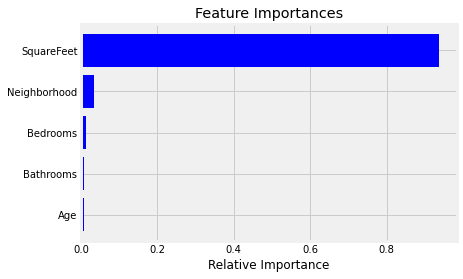

In [42]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Normalisation des données
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

liste_variables  = ['SquareFeet', 'Bedrooms', 'Bathrooms', 'Age', 'Neighborhood']

# Entraînement du modèle
model =  RandomForestRegressor(n_estimators = 30,
                                max_depth = 10,
                                random_state=0)
rf = model.fit(X_train_scaled, y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)
# style du graphique 
plt.style.use('fivethirtyeight')
%matplotlib inline
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
plt.xlabel('Relative Importance')